## Check where this runs
***

In [1]:
import os
os.environ["our_new"] = ""
envs = os.getenv("LOGNAME")
print(envs)
assert envs == "hughharford"
# if you get an error here, the notebook is not running in HSTH's expected place, and adjusts will be required.
print(os.environ)
if envs == "hughharford":
    environment_running = 'laptop'
else:
    environment_running = 0

hughharford
environ({'BUNDLER_EDITOR': 'code', 'CHROME_DESKTOP': 'code-url-handler.desktop', 'COLORTERM': 'truecolor', 'DBUS_SESSION_BUS_ADDRESS': 'unix:path=/run/user/1000/bus', 'DESKTOP_SESSION': 'ubuntu', 'DISPLAY': ':0', 'EDITOR': 'code', 'ELECTRON_NO_ATTACH_CONSOLE': '1', 'GDK_BACKEND': 'x11', 'GDMSESSION': 'ubuntu', 'GNOME_DESKTOP_SESSION_ID': 'this-is-deprecated', 'GNOME_SETUP_DISPLAY': ':1', 'GNOME_SHELL_SESSION_MODE': 'ubuntu', 'GNOME_TERMINAL_SCREEN': '/org/gnome/Terminal/screen/2ffbd9f5_9c58_49f8_869d_5fe1e8e07518', 'GNOME_TERMINAL_SERVICE': ':1.100', 'GTK_MODULES': 'gail:atk-bridge', 'HOME': '/home/hughharford', 'HOMEBREW_NO_ANALYTICS': '1', 'LANG': 'en_US.UTF-8', 'LANGUAGE': 'en_GB:en', 'LC_ALL': 'en_US.UTF-8', 'LESS': '-R', 'LOGNAME': 'hughharford', 'LSCOLORS': 'Gxfxcxdxbxegedabagacad', 'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*

# IMPORTS
***

In [15]:
import os
import time
            # data sourcing:
import csv
            # databases:
import sqlite3
            # useful other
from collections import defaultdict
            # data toolkit:
import numpy as np
import pandas as pd
import dask.dataframe as dd
            # plotting
import matplotlib.pyplot as plt
%matplotlib inline  

if not environment_running == 'laptop':
    %pip install seaborn
    # no seaborn by default in AWS SageMaker.
    
import seaborn as sns

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
 # Visualizing Pipelines in HTML
from sklearn import set_config; set_config(display='diagram')

## Establish paths

In [5]:
# check raw data archive path extant:
atp_data_path = os.path.join('..','raw_data','archive')
assert os.path.exists(atp_data_path)

# set read_data path for chunking later on:
read_data_path = os.path.join('..','raw_data','read_data')
assert os.path.exists(read_data_path) 

# check initial data file expected are extant:
matches_data_path_full = os.path.join(atp_data_path, 'all_matches.csv')
assert os.path.exists(matches_data_path_full)

# Show getting 50k rows works:

In [6]:
# this works to convert dates as reading in. good news
schema = {'start_date': 'datetime64[ns]', 'end_date': 'datetime64[ns]'}
matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None).astype(schema)

/tmp/ipykernel_21452/2131584680.py:3: DtypeWarning: Columns (8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None).astype(schema)


In [12]:
matches_df_1st_50k.dtypes.head()
# this confirms astype(schema) works, so date manipulation is available

start_date       datetime64[ns]
end_date         datetime64[ns]
location                 object
court_surface            object
prize_money             float64
dtype: object

In [13]:
matches_df_1st_50k.columns

Index(['start_date', 'end_date', 'location', 'court_surface', 'prize_money',
       'currency', 'year', 'player_id', 'player_name', 'opponent_id',
       'opponent_name', 'tournament', 'round', 'num_sets', 'sets_won',
       'games_won', 'games_against', 'tiebreaks_won', 'tiebreaks_total',
       'serve_rating', 'aces', 'double_faults', 'first_serve_made',
       'first_serve_attempted', 'first_serve_points_made',
       'first_serve_points_attempted', 'second_serve_points_made',
       'second_serve_points_attempted', 'break_points_saved',
       'break_points_against', 'service_games_won', 'return_rating',
       'first_serve_return_points_made', 'first_serve_return_points_attempted',
       'second_serve_return_points_made',
       'second_serve_return_points_attempted', 'break_points_made',
       'break_points_attempted', 'return_games_played', 'service_points_won',
       'service_points_attempted', 'return_points_won',
       'return_points_attempted', 'total_points_won', 'total

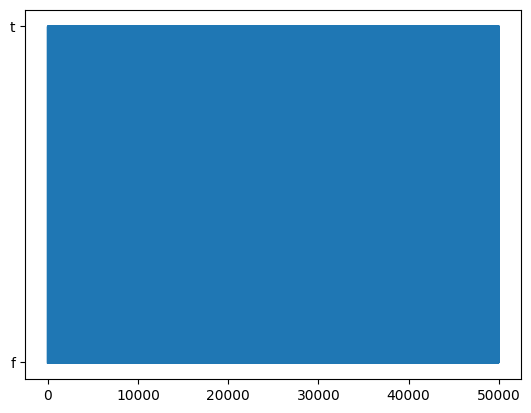

In [14]:
plt.plot(matches_df_1st_50k.player_victory)

### Boolean transformer, can apply to many columns

In [23]:

boolean_transformer = Pipeline([
    ('fill_empties', SimpleImputer(strategy='constant', missing_values=np.nan, fill_value="empty")),
    ('impute_t', SimpleImputer(strategy='constant', missing_values="t", fill_value=True)),
    ('impute_f', SimpleImputer(strategy='constant', missing_values="f", fill_value=False)),
])